In [24]:

from Modules import widget,data_cleaning, data, simple_visualisation

In [10]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Acquisition de données (25 %)

In [ ]:
year_range = [2016, 2024]  
data.get_data(year_range)


In [ ]:
#load all the data
year_list = [2016, 2017, 2018] 
all_data=data.load_data(year_list)

2. Outil de débogage interactif (10%)

In [11]:
widget.widget([2016,2017])

Loading data for season 2016
Data for season 2016 loaded successfully.
Loading data for season 2017
Data for season 2017 loaded successfully.


interactive(children=(Dropdown(description='Select Year', options=(2016, 2017), value=2016), Output()), _dom_c…

3. Nettoyer les donnees (10%)

In [ ]:
data_cleaning.create_dataframes(year_list, data.load_data(year_list))

In [17]:
years_to_load = [2018, 2019, 2020]  
dataframes = data_cleaning.load_dataframes(years_to_load)


In [18]:
for year, df in dataframes.items():
    print(f'DataFrame pour l\'année {year}:')
    print(df.tail())

DataFrame pour l'année 2018:
               ID  Sort Order   Time  Period  Event ID       Team  \
80473  2018021271         567  15:37       3       489     Sharks   
80474  2018021271         574  16:33       3       493  Avalanche   
80475  2018021271         588  18:39       3       499  Avalanche   
80476  2018021271         589  18:40       3       500  Avalanche   
80477  2018021271         595  19:15       3       502     Sharks   

               Type Coordinates Shooter ID Goalie ID Shot Type  Empty Net  \
80473  shot-on-goal   (-67, 19)        Joe    Semyon      slap      False   
80474  shot-on-goal    (78, -1)    Gabriel    Martin     wrist      False   
80475  shot-on-goal   (82, -10)    Gabriel    Martin     wrist      False   
80476  shot-on-goal    (81, -1)       Carl    Martin     wrist      False   
80477          goal   (-74, -4)    Micheal       NaN     wrist       True   

                 Force Type  
80473         Even Strength  
80474  Empty Net Power Play  
804

4. Visualisations Simples (25%)

Graphique comparant les types de tirs de toutes les équipes dans une saison (Saison 2020-2021 par exemple)

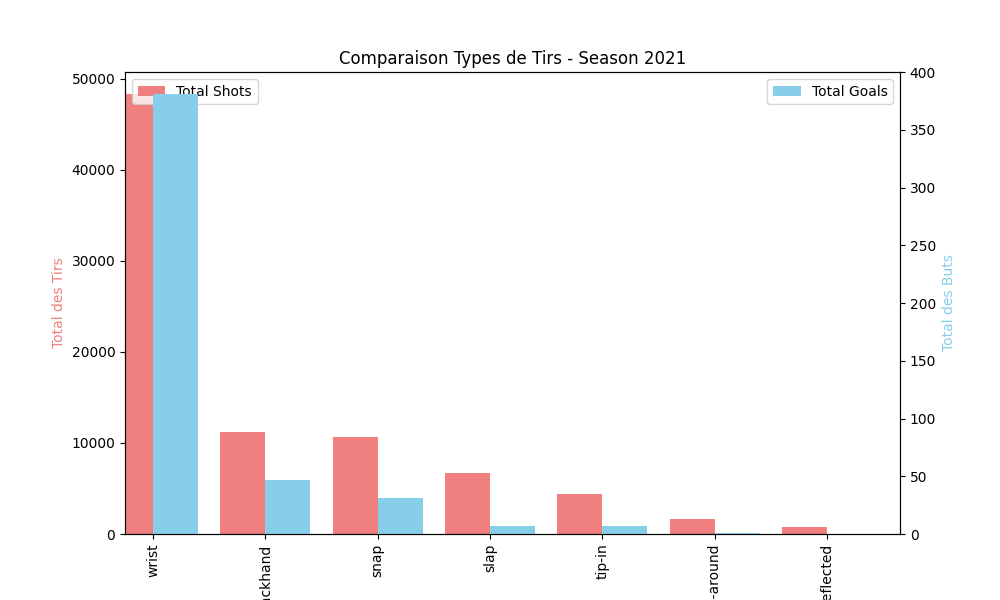

In [72]:
simple_visualisation.shotsComparaison(dataframes, 2021)

Pour chaque saison entre 2018-19 et 2020-21, un graphique montrant la relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but

e:\GitHub Repository\IFT6358\Modules\simple_visualisation.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Goal'] = df['Type'] == 'goal'


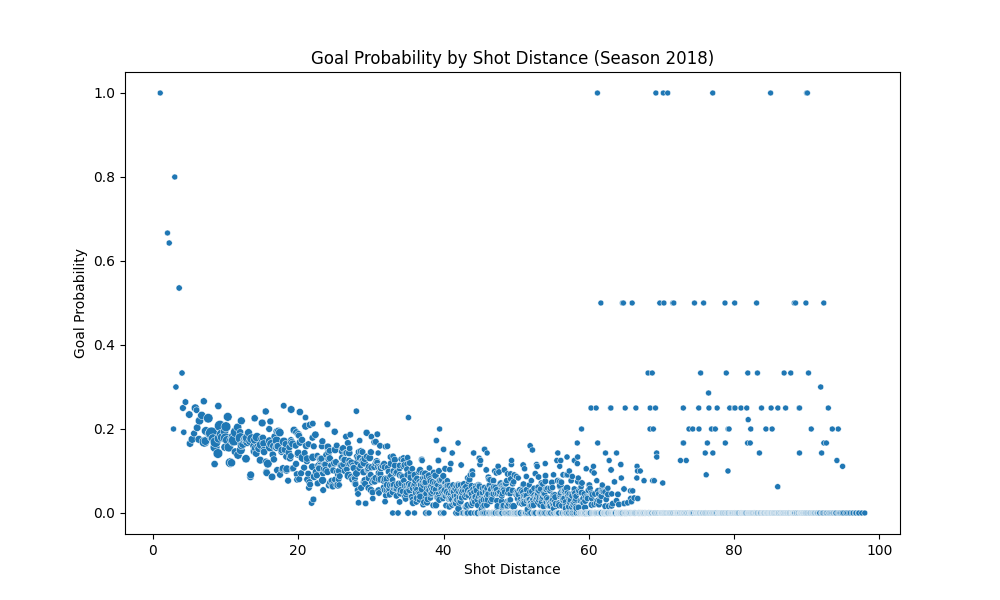

e:\GitHub Repository\IFT6358\Modules\simple_visualisation.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Goal'] = df['Type'] == 'goal'


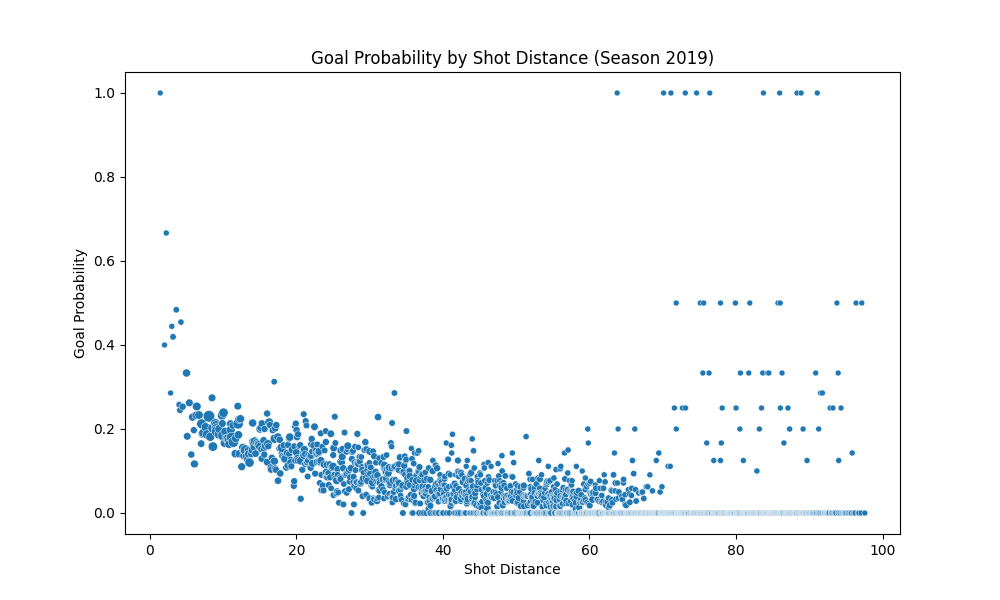

e:\GitHub Repository\IFT6358\Modules\simple_visualisation.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


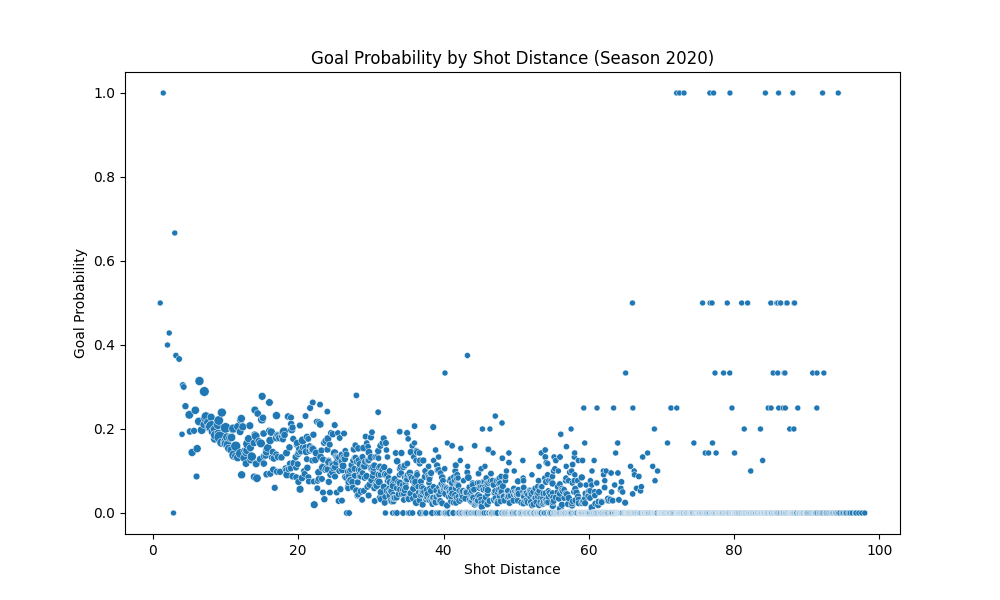

In [48]:
simple_visualisation.distancegoal_relationship(dataframes, 2018)
simple_visualisation.distancegoal_relationship(dataframes, 2019)
simple_visualisation.distancegoal_relationship(dataframes, 2020)

Graphique qui montre le pourcentage de buts en fonction à la fois de la distance par rapport au filet et de la catégorie de types de tirs

e:\GitHub Repository\IFT6358\Modules\simple_visualisation.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.heatmap(shot_distance_pivot, cmap='Blues', annot=False, linewidths=0.5)
e:\GitHub Repository\IFT6358\Modules\simple_visualisation.py:138: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  plt.xlabel('Shot Distance')


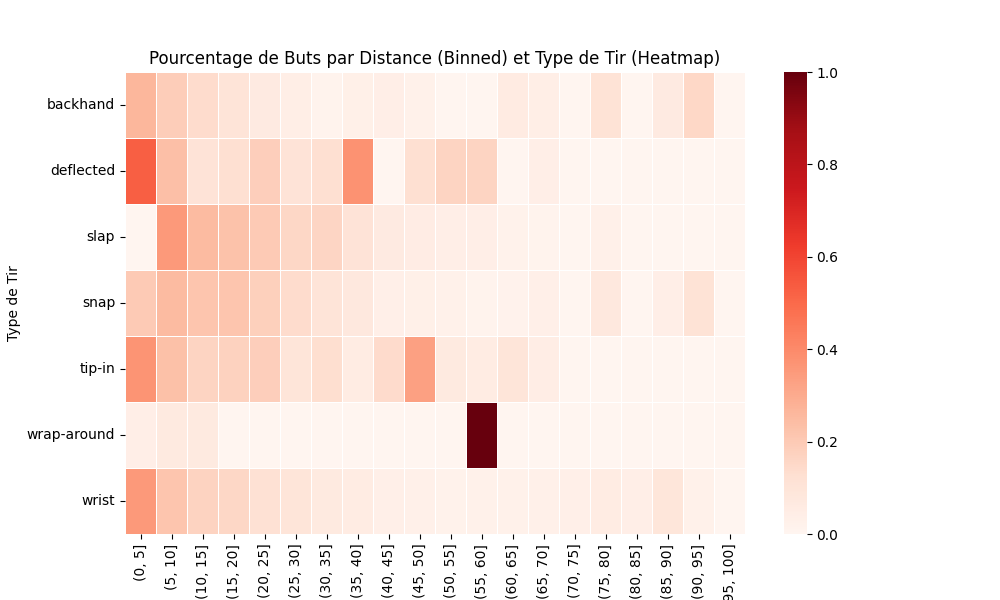

In [81]:
simple_visualisation.distance_goalpercentage(dataframes, 2020)